# Predicting Heart Disease Based On Physical Characteristics of Patients

# Introduction

Heart disease is an often-lethal condition, and being able to accurately predict if patients have it, based on easy-to-observe qualities, would allow for quicker action from doctors and better patient outcomes. So here we ask the question: is it possible to predict whether a patient has heart disease based on a set of measurable factors? To build a model that could answer this, we used the publicly-available heart disease dataset donated by the Hungarian Institute of Cardiology, the University Hospitals of Zurich and Basel, the V. A. Medical Center of Long Beach, and the Cleveland Clinic Foundation. Each row in this dataset represents a patient, and the columns store physical, health-related information about each patient — such as their age, sex, type of chest pain, and resting blood pressure. There are 14 variables in total. The column we are attempting to predict has values of either “true” or “false”, indicating whether a patient has some variety of heart disease. The dataset contains four databases, each with around 100 to 300 patients, donated by institutions in Switzerland, Hungary, and two locations in America. We trained and tested our model on data from all of the databases, as this gives us a larger sample size, and an additional variable to work with (region). This brings the total number of columns in our dataset to 15.

## Preliminary Exploratory Data Analysis

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [4]:



cleveland_data<- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                         col_name = FALSE)
colnames(cleveland_data)<- c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num")
cleveland_data<- mutate(cleveland_data, region="Cleveland")
cleveland_data$num<-ifelse(cleveland_data$num==0,"true","false")


cleveland_data               






hungarian_data<-read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data",
                          col_name = FALSE)
colnames(hungarian_data)<- c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num")
hungarian_data<- mutate(hungarian_data, region="Hungarian")
hungarian_data$num<-ifelse(hungarian_data$num==0,"true","false")
hungarian_data

switzerland_data<-read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data",
                            col_name = FALSE)
colnames(switzerland_data)<-c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num")
switzerland_data<- mutate(switzerland_data, region="Switzerland")
switzerland_data$num<-ifelse(switzerland_data$num==0,"true","false")
switzerland_data


va_data<-read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data",
                   col_name = FALSE)
colnames(va_data)<-c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal","num")
va_data<- mutate(va_data, region="VA_Long_Beach")
va_data$num<-ifelse(va_data$num==0,"true","false")
va_data

heart_disease_data<-rbind(cleveland_data,hungarian_data,switzerland_data,va_data)
heart_disease_data <- heart_disease_data |> filter(trestbps != 0) #Having 0 blood pressure is impossible, this outlier is filtered out

heart_disease_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,region
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,true,Cleveland
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,false,Cleveland
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,false,Cleveland
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,false,Cleveland
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,false,Cleveland
38,1,3,138,175,0,0,173,0,0.0,1,?,3.0,true,Cleveland


Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,region
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
28,1,2,130,132,0,2,185,0,0,?,?,?,true,Hungarian
29,1,2,120,243,0,0,160,0,0,?,?,?,true,Hungarian
29,1,2,140,?,0,0,170,0,0,?,?,?,true,Hungarian
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,2,?,?,false,Hungarian
58,0,2,180,393,0,0,110,1,1,2,?,7,false,Hungarian
65,1,4,130,275,0,1,115,1,1,2,?,?,false,Hungarian


Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X6, X7, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X5, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,region
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
32,1,1,95,0,?,0,127,0,.7,1,?,?,false,Switzerland
34,1,4,115,0,?,?,154,0,.2,1,?,?,false,Switzerland
35,1,4,?,0,?,0,130,1,?,?,?,7,false,Switzerland
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
72,1,3,160,0,?,2,114,0,1.6,2,2,?,true,Switzerland
73,0,3,160,0,0,1,121,0,0,1,?,3,false,Switzerland
74,1,2,145,0,?,1,123,0,1.3,1,?,?,false,Switzerland


Rows: 200 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X8, X9, X10, X11, X12, X13
dbl (5): X1, X2, X3, X7, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,region
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
63,1,4,140,260,0,1,112,1,3,2,?,?,false,VA_Long_Beach
44,1,4,130,209,0,1,127,0,0,?,?,?,true,VA_Long_Beach
60,1,4,132,218,0,1,140,1,1.5,3,?,?,false,VA_Long_Beach
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,1,4,122,223,1,1,100,0,0,?,?,6,false,VA_Long_Beach
58,1,4,?,385,1,2,?,?,?,?,?,?,true,VA_Long_Beach
62,1,2,120,254,0,2,93,1,0,?,?,?,false,VA_Long_Beach


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,region
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,true,Cleveland
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,false,Cleveland
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,false,Cleveland
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,1,4,122,223,1,1,100,0,0,?,?,6,false,VA_Long_Beach
58,1,4,?,385,1,2,?,?,?,?,?,?,true,VA_Long_Beach
62,1,2,120,254,0,2,93,1,0,?,?,?,false,VA_Long_Beach


In [3]:
heart_disease_split <- initial_split(heart_disease_data, prop = 0.75, strata = num)
heart_disease_train <- training(heart_disease_split)
heart_disease_test <- testing(heart_disease_split)

heart_disease_train

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,region
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,false,Cleveland
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,false,Cleveland
62,0,4,140,268,0,2,160,0,3.6,3,2.0,3.0,false,Cleveland
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
51,0,4,114,258,1,2,96,0,1,1,?,?,true,VA_Long_Beach
62,1,1,?,139,0,1,?,?,?,?,?,?,true,VA_Long_Beach
58,1,4,?,385,1,2,?,?,?,?,?,?,true,VA_Long_Beach


In [4]:


tidy_heart_disease_data<- heart_disease_train|>
                          select(region,sex,cp,thalach,trestbps,num)|>
                          filter(cp!="?",sex!="?",thalach!="?",trestbps!="?")|>
                          mutate(region=as.factor(region),
                                 sex=as.numeric(sex),
                                 cp=as.numeric(cp),
                                 thalach=as.numeric(thalach),
                                 trestbps=as.numeric(trestbps),
                                 num = as.factor(num))
tidy_heart_disease_data

data_miss_num<-tidy_heart_disease_data|>
map_df(is.na)|>
map_df(sum)
data_miss_num
data_obs_num<-tidy_heart_disease_data|>
summarize(n_cp=sum(!is.na(cp)),
          n_region=sum(!is.na(region)),
          n_sex=sum(!is.na(sex)),
          n_thalach=sum(!is.na(thalach)),
          n_trestbps=sum(!is.na(trestbps)))
data_obs_num

heart_rate_mean<-tidy_heart_disease_data|>
            summarize(mean.rate=mean(thalach, na.rm=TRUE))
heart_rate_mean

blood_pressure_mean<-tidy_heart_disease_data|>
            summarize(mean.pressure=mean(trestbps, na.rm=TRUE))
blood_pressure_mean



region,sex,cp,thalach,trestbps,num
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
Cleveland,1,4,108,160,false
Cleveland,1,4,129,120,false
Cleveland,0,4,160,140,false
⋮,⋮,⋮,⋮,⋮,⋮
VA_Long_Beach,1,4,96,130,true
VA_Long_Beach,1,3,151,134,true
VA_Long_Beach,0,4,96,114,true


region,sex,cp,thalach,trestbps,num
<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0


n_cp,n_region,n_sex,n_thalach,n_trestbps
<int>,<int>,<int>,<int>,<int>
643,643,643,643,643


mean.rate
<dbl>
137.5117


mean.pressure
<dbl>
132.2473


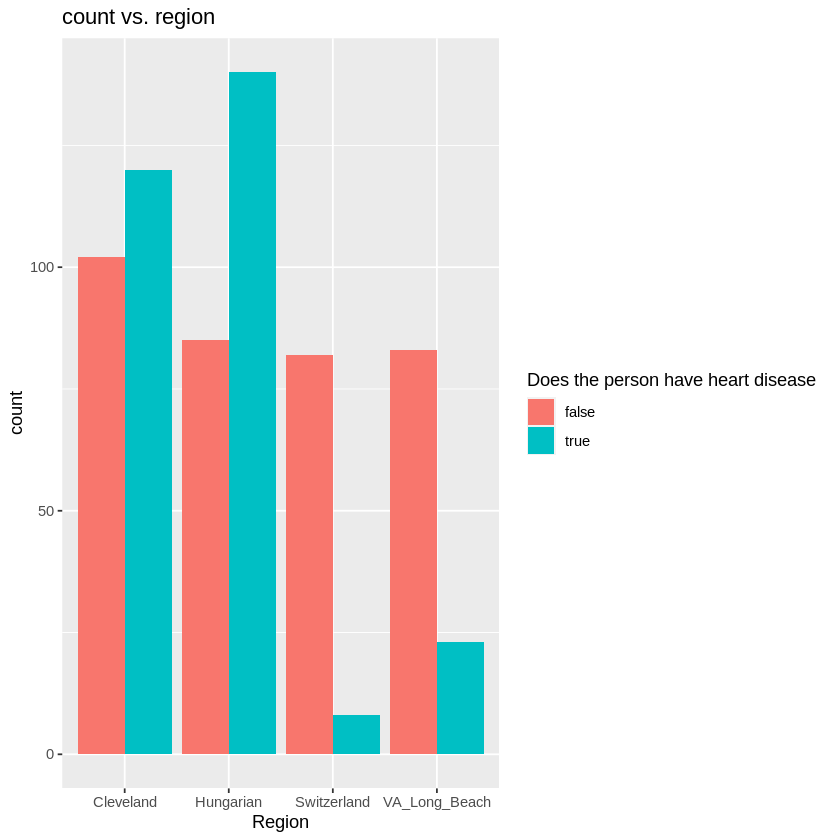

In [5]:
region_plot<- tidy_heart_disease_data|>
                 ggplot(aes(x = region, fill = num)) + 
    geom_bar(position = 'dodge') + 
    xlab("Region") +
    ylab("count") +
    labs(fill = "Does the person have heart disease") +
    ggtitle("count vs. region")


region_plot

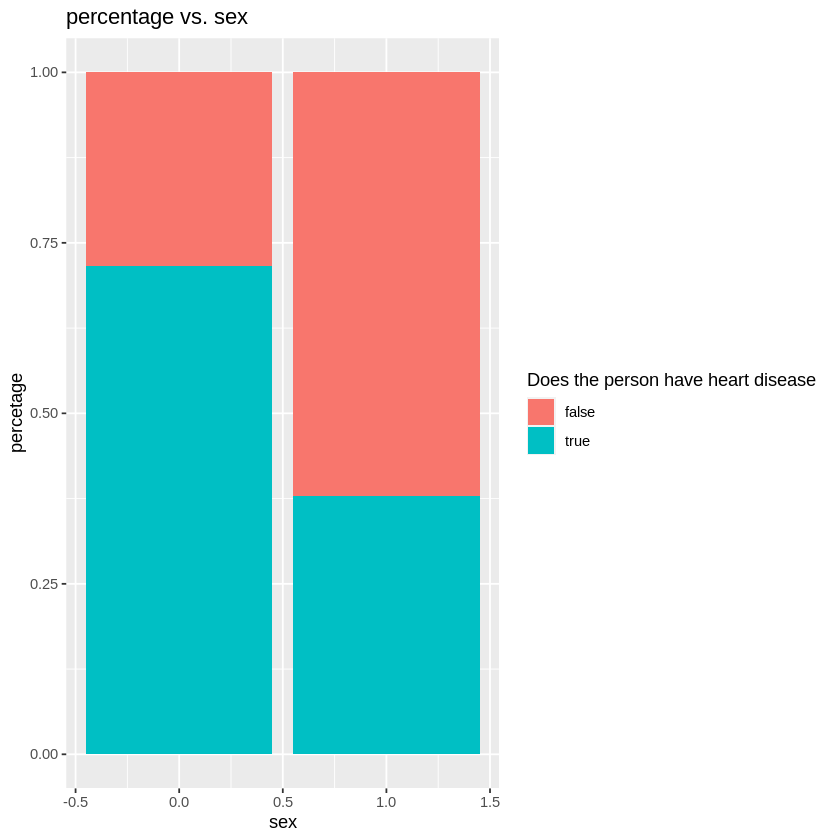

In [6]:

sex_plot<- tidy_heart_disease_data|>
                 ggplot(aes(x = sex, fill = num)) + 
    geom_bar(position = 'fill') + 
    xlab("sex") +
    ylab("percetage") +
    labs(fill = "Does the person have heart disease") +
    ggtitle("percentage vs. sex")


sex_plot

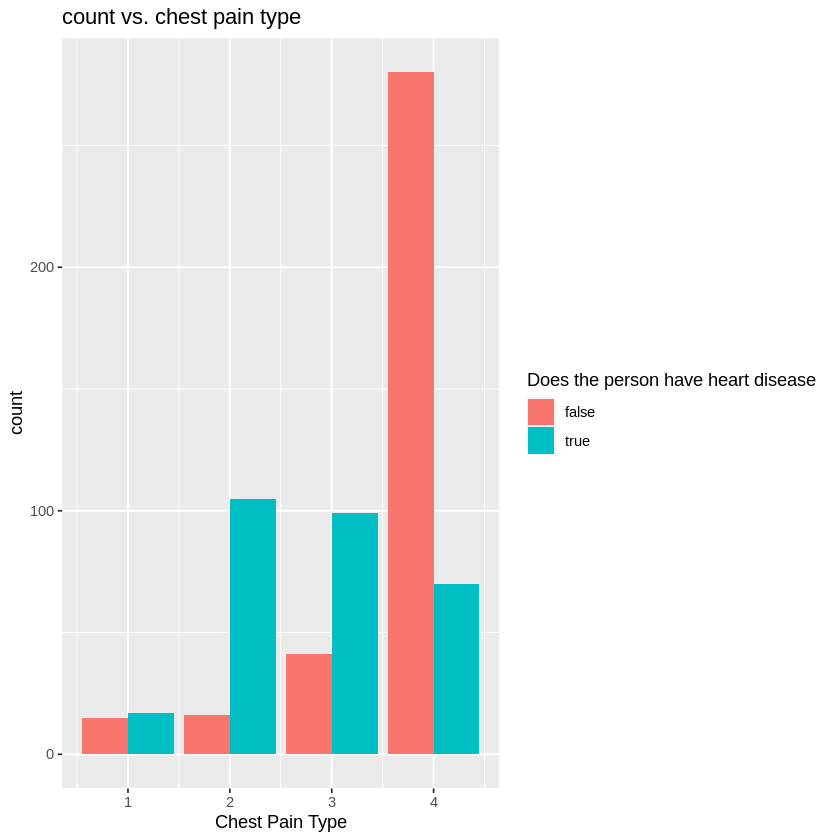

In [7]:

chest_pain_plot<- tidy_heart_disease_data|>
                 ggplot(aes(x = cp, fill = num)) + 
    geom_bar(position = 'dodge') + 
    xlab("Chest Pain Type") +
    ylab("count") +
    labs(fill = "Does the person have heart disease") +
    ggtitle("count vs. chest pain type")


chest_pain_plot

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,region
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,true,Cleveland
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,false,Cleveland
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,false,Cleveland
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55,1,4,122,223,1,1,100,0,0,?,?,6,false,VA_Long_Beach
58,1,4,?,385,1,2,?,?,?,?,?,?,true,VA_Long_Beach
62,1,2,120,254,0,2,93,1,0,?,?,?,false,VA_Long_Beach


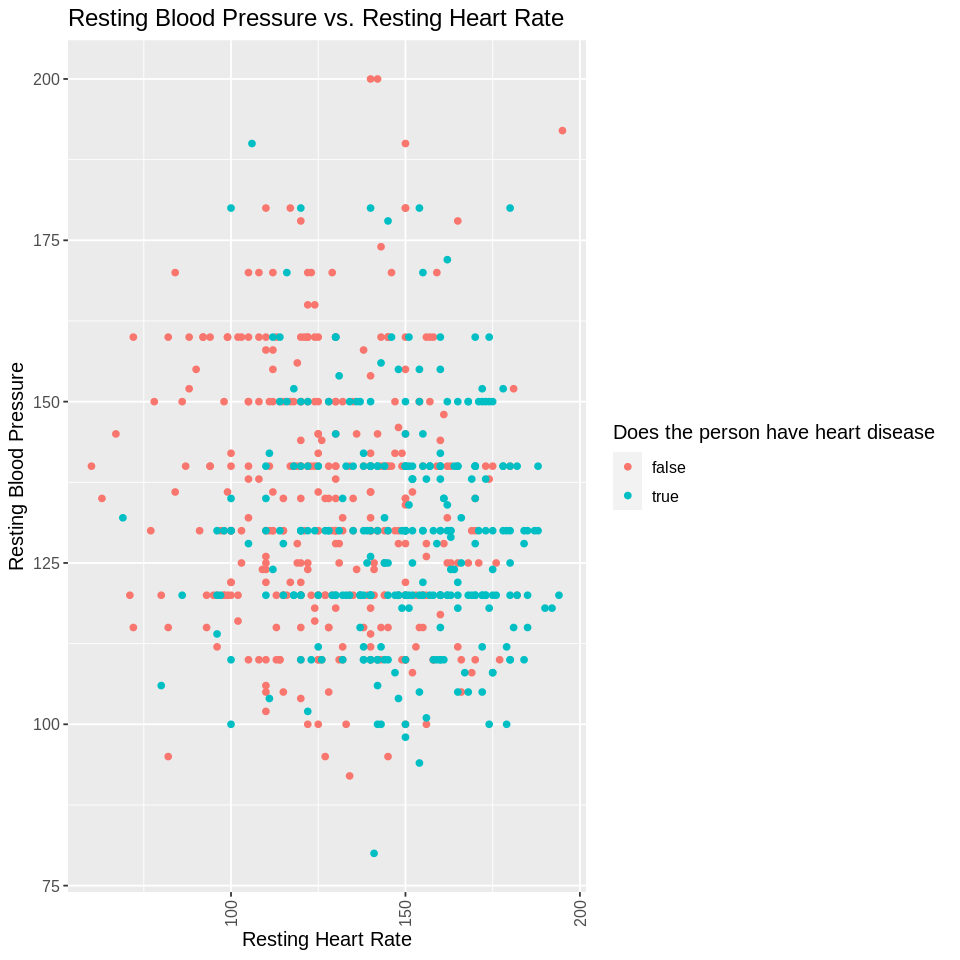

In [8]:
options(repr.plot.width = 8, repr.plot.height = 8)

rate_pressure_plot<- tidy_heart_disease_data|>
                 ggplot(aes(x = thalach,y=trestbps, color=num)) + 
    geom_point() + 
    xlab("Resting Heart Rate") +
    ylab("Resting Blood Pressure") +
    labs(color = "Does the person have heart disease") +
    theme(text = element_text(size = 12), axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
    ggtitle("Resting Blood Pressure vs. Resting Heart Rate")


rate_pressure_plot

heart_disease_data

## Methods

In order to decide what variables will be used as predictors for this model, we will employ forward selection, using the metric of accuracy. This will allow us to reliably determine, without assumptions, which variables contribute to improving the accuracy of the model and which do not. Because we have not yet done the analysis (and thus haven’t performed the forward selection yet) we cannot state which columns we will use at this time. To visualize the results, we will plot different choices of *k* for the model vs the accuracy that this choice of parameter produces. We will use this visualization to determine which choice of *k* results in the best accuracy.

## Expected Outcomes And Significance

### What do you expect to find?

With this data analysis, we would expect to find a correlation between whether or not an individual has a heart disease, and certain variables that we could use to predict it. For example, if an individual has a higher than average resting blood pressure, and higher than average cholesterol, we would expect for them to have a similarly higher chance of having a heart disease. This prediction is based on previous knowledge of heart diseases, but with our analysis we would expect to find some other factors that point to an individual having a higher or lower chance of contracting a heart disease. 

### What impact could such findings have?

These findings could allow hospitals to more accurately predict if an individual has a heart disease by attempting to classify it using our data set. It could also reduce the workload of doctors and nurses by automatically calculating how likely it is for someone to have a heart disease, which could get rid of the easy diagnoses and let doctors take over for the more difficult ones. By capturing the most impactful properties that indicate heart disease, we can also attempt to figure out methods of treatment and prevention that directly influence these properties.

### What future questions could this lead to?

This could lead to further questions about medical diagnoses from data, and if they could ever have any real life applications in the medical field. For example, based on the properties of a mole, could we predict if it is harmful or not? On the other hand, we could also ask the question of how legitimate our model is, by using a completely different heart disease data set and comparing the accuracy. Finally, as we have access to heart disease data from a variety of locations, we could ask the question: do the characteristics of heart disease remain consistent in different regions of the world? If they do not, we could try to figure out how it is different and why.